# Réseaux pleinement connectés 

Cet exercice fait suite au devoir 1.  L'objectif ici est d'implanter un réseau pleinement connecté avec une approche plus modulaire. Pour chaque couche, vous serez appelé à implanter une fonction `forward` et une fonction `backward`. La fonction `forward` reçoit en entrée un tenseur `x`, des poids `w` et possiblement d'autres parameters, et retourne le tenseur de sortie de la couche `out`.  La fonction retourne aussi une variable `cache`  contenant des données utilisés pour la rétropropagation (fonction `backward`).  La structure de la fonction `forward` est la suivante : 

```python
def layer_forward(x, w):
  """ Receive inputs x and weights w """
  # Do some computations ...
  z = # ... some intermediate value
  # Do some more computations ...
  out = # the output
   
  cache = (x, w, z, out) # Values we need to compute gradients
   
  return out, cache
```

N'oubliez pas que `x` est une `batch` et donc conbient plus d'un élément.

En rétropropagation, la fonction `backward` de la couche reçoit en entrée un tenseur de dérivées `dout` ainsi que la liste `cache` calculée lors de la propagation avant (fonction `forward`).  Elle retourne deux tenseurs de gradients: un par rapport à ses entrée (`dx`) et un par rapport à ses poids (`dw`) (et parfois un par rapport aux bias `db`).  La structure de la fonction `backward` est la suivante : 

```python
def layer_backward(dout, cache):
  """
  Receive derivative of loss with respect to outputs and cache,
  and compute derivative with respect to inputs.
  """
  # Unpack cache values
  x, w, z, out = cache
  
  # Use values in cache to compute derivatives
  dx = # Derivative of loss with respect to x
  dw = # Derivative of loss with respect to w
  
  return dx, dw
```

Une fois ce type de couches implanté, il sera possible de les combiner ensemble et ainsi construire des réseaux de neurones de différentes architectures.

En plus des réseaux pleinement connectés, nous explorerons différents algorithme de descente de gradient et  introduirons *Dropout* et *Batch Norm*.
  

In [1]:
# As usual, a bit of setup

#import time
import numpy as np
import matplotlib.pyplot as plt
from ift725.layers import *
from ift725.classifiers.fc_net import *
from ift725.data_utils import get_CIFAR10_data
from ift725.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from ift725.solver import Solver
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

print('setup done!')

run the following from the ift725 directory and try again:
python setup.py build_ext --inplace
You may also need to restart your iPython kernel
setup done!


In [2]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in data.items():
  print('%s: ' % k, v.shape)

X_train:  (49000, 3, 32, 32)
y_train:  (49000,)
X_val:  (1000, 3, 32, 32)
y_val:  (1000,)
X_test:  (1000, 3, 32, 32)
y_test:  (1000,)


# Couche pleinement connectée : propagation avant
Dans le fichier `ift725/layers.py`, vous devez coder la fonction `forward_fully_connected` et la tester avec le code de la cellule suivante.

In [3]:
# Test the forward_fully_connected function : batch 1 and 1 output neuron

input_shape = (2, 2, 3) # an 2x2x3 input variable (a CIFAR10 image would have a 32x32x3 shape)

input_size = np.prod(input_shape) # here 12
weight_size = np.prod(input_shape) # here 12

x = np.floor(np.linspace(-0.1, 0.5, num=input_size).reshape(1, *input_shape)*10)
w = np.floor(np.linspace(-0.2, 0.3, num=weight_size).reshape(weight_size, 1)*10)
b = np.linspace(-0.3, 0.1, num=1)

print('x-shape  = ', x.shape)
print('w-shape  = ', w.shape)
print('b-shape  = ', b.shape)

out, _ = forward_fully_connected(x, w, b)
correct_out = 36.7

print('out = ', out)
print('correct_out = ', correct_out)

# Compare your output with ours. The error should be around 1e-9.
print('Testing forward_fully_connected function:')
print('difference: ', rel_error(out, correct_out))

x-shape  =  (1, 2, 2, 3)
w-shape  =  (12, 1)
b-shape  =  (1,)
out =  [[36.7]]
correct_out =  36.7
Testing forward_fully_connected function:
difference:  0.0


In [4]:
# Test the forward_fully_connected function : batch 2 and 1 output neuron

num_inputs = 2          # batch of 2 input variables
input_shape = (2, 2, 3) # an 2x2x3 input variable (a CIFAR10 image would have a 32x32x3 shape)

input_size = num_inputs * np.prod(input_shape) # here 2x12 = 24
weight_size = np.prod(input_shape) # here 12

x = np.floor(np.linspace(-0.1, 0.5, num=input_size).reshape(num_inputs, *input_shape)*10)
w = np.floor(np.linspace(-0.2, 0.3, num=weight_size).reshape(weight_size, 1)*10)
b = np.linspace(-0.3, 0.1, num=1)

print('x-shape  = ', x.shape)
print('w-shape  = ', w.shape)
print('b-shape  = ', b.shape)

out, _ = forward_fully_connected(x, w, b)
correct_out = np.array([14.7, 20.7])

print('out = ', out)
print('correct_out = ', correct_out)

# Compare your output with ours. The error should be around 1e-9.
print('Testing forward_fully_connected function:')
print('difference: ', rel_error(out.T, correct_out))

x-shape  =  (2, 2, 2, 3)
w-shape  =  (12, 1)
b-shape  =  (1,)
out =  [[14.7]
 [20.7]]
correct_out =  [14.7 20.7]
Testing forward_fully_connected function:
difference:  0.0


In [5]:
# Test the forward_fully_connected function : batch 2 and 2 output neurons
num_inputs = 2          # batch of 2 input variables
input_shape = (2, 2, 3) # each variable as a 2x2x3 shape (a CIFAR10 RBG image would have a 32x32x3 shape)
output_dim = 2          # the output has 2 neurons

input_size = num_inputs * np.prod(input_shape)  #here 2x2x2x3 = 24
weight_size = output_dim * np.prod(input_shape) #here 2x12 = 24

x = np.floor(np.linspace(-0.1, 0.5, num=input_size).reshape(num_inputs, *input_shape)*10)
w = np.floor(np.linspace(-0.2, 0.3, num=weight_size).reshape(np.prod(input_shape), output_dim)*10)
b = np.linspace(-0.3, 0.1, num=output_dim)

print('x-shape  = ', x.shape)
print('w-shape  = ', w.shape)
print('b-shape  = ', b.shape)

out, _ = forward_fully_connected(x, w, b)
correct_out = np.array([[ 12.7,  14.1],
                        [ 11.7,  23.1]])

print('out = ', out)
print('correct_out = ', correct_out)

# Compare your output with ours. The error should be around 1e-9.
print('Testing forward_fully_connected function:')
print('difference: ', rel_error(out, correct_out))

x-shape  =  (2, 2, 2, 3)
w-shape  =  (12, 2)
b-shape  =  (2,)
out =  [[12.7 14.1]
 [11.7 23.1]]
correct_out =  [[12.7 14.1]
 [11.7 23.1]]
Testing forward_fully_connected function:
difference:  0.0


# Couche pleinement connectée : rétro-propagation
If faut maintenant implanter la fonction `backward_fully_connected` et tester votre code avec un gradient numérique.

In [6]:
# Test the backward_fully_connected function
# Here a case for a batch of 10 elements
# Each elements has a 2x3 size
# The layer has 5 output neurons

x = np.random.randn(10, 2, 3)  # batch of 10 elements, each of size 2x3
w = np.random.randn(6, 5)      # 2x3=6 weigts times 5 output neurones
b = np.random.randn(5)         # one bias for each output neurone
dout = np.random.randn(10, 5)  # the upcoming gradient at each output neuron and for each element of the batch

dx_num = eval_numerical_gradient_array(lambda x: forward_fully_connected(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: forward_fully_connected(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: forward_fully_connected(x, w, b)[0], b, dout)

_, cache = forward_fully_connected(x, w, b)
dx, dw, db = backward_fully_connected(dout, cache)

# The error should be around 1e-10
print('Testing backward_fully_connected function:')
print('dx error: ', rel_error(dx_num, dx))  #Gradient with respect to the input x : size 10x2x3
print('dw error: ', rel_error(dw_num, dw))  #Gradient with respect to the weights w : size 5x6
print('db error: ', rel_error(db_num, db))  #Gradient with respect to the bias : size 5

Testing backward_fully_connected function:
dx error:  5.738517706981203e-10
dw error:  1.674807096796757e-10
db error:  3.0812176252395395e-11


# Couche ReLU : propagation avant
Il faut implanter la fonction d'activation ReLU avec la fonction `relu_forward`.  Testez votre implantation avec la cellule que voici:

In [7]:
# Test the relu_forward function

x = np.linspace(-0.5, 0.5, num=12).reshape(3, 4)

out, _ = forward_relu(x)
correct_out = np.array([[ 0.,          0.,          0.,          0.,        ],
                        [ 0.,          0.,          0.04545455,  0.13636364,],
                        [ 0.22727273,  0.31818182,  0.40909091,  0.5,       ]])

# Compare your output with ours. The error should be around 1e-8
print('Testing forward_relu function:')
print('difference: ', rel_error(out, correct_out))

Testing forward_relu function:
difference:  4.999999798022158e-08


# Couche ReLU : rétropropagation
Maintenant il faut implanter la rétro-propagation pour une fonction d'activation ReLU via la fonction `relu_backward`.  Testez votre implantation avec le gradient numérique que voici:

In [8]:
x = np.random.randn(2, 2)
dout = np.random.randn(*x.shape) # Upstream gradient that retropropagates at that layer
print("x = ", x)
print("dout  = ", dout)

dx_num = eval_numerical_gradient_array(lambda xx: forward_relu(xx)[0], x, dout)

_, cache = forward_relu(x)
dx = backward_relu(dout, cache)
# The error should be around 1e-12
print('Testing backward_relu function:')
print('dx error: ', rel_error(dx_num, dx))

x =  [[-1.26301931 -0.74307561]
 [-0.59484589  1.07007521]]
dout  =  [[-2.31495006  0.6526706 ]
 [-1.77484294  0.94028161]]
Testing backward_relu function:
dx error:  3.2755348691829362e-12


# Couches "Combo"
Souvent, on combine une couche pleinement connectée avec une fonction d'activation comme ReLU. Afin de simplifier ces situations, nous avons différentes fonctions à cet effet dans `ift725/layer_combo.py`.

Pour l'instant, nous porterons notre attention sur les fonctions `forward_fully_connected_transform_relu` et `backward_fully_connected_transform_relu`.  Vous pouvez vérifier le code à l'aide de la vérification numérique que voici:

In [9]:
from ift725.layer_combo import forward_fully_connected_transform_relu, backward_fully_connected_transform_relu

x = np.random.randn(2, 3, 4)  # Batch of 2 elements of size 3x4
w = np.random.randn(12, 10)   # 10 output neurons, each associated with 12=3x4 weights
b = np.random.randn(10)       # 10 biases
dout = np.random.randn(2, 10) # up stream gradient for each neuron (10) and each batch element (2)

out, cache = forward_fully_connected_transform_relu(x, w, b)
dx, dw, db = backward_fully_connected_transform_relu(dout, cache)

dx_num = eval_numerical_gradient_array(lambda xx: forward_fully_connected_transform_relu(xx, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda ww: forward_fully_connected_transform_relu(x, ww, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda bb: forward_fully_connected_transform_relu(x, w, bb)[0], b, dout)

# Error should be around 1e-10
print('Testing forward_fully_connected_transform_relu:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing forward_fully_connected_transform_relu:
dx error:  3.621487184045041e-11
dw error:  1.5748747323854265e-10
db error:  3.275629260933637e-12


# Fonctions de perte : Softmax et SVM
Au devoir 1, vous avez implanter ces deux fonctions de perte.  Vous devez donc récupérer votre code et l'adapter aux fonctions `softmax_loss` et `svm_loss` du fichier `ift725/layers.py`.

Afin de vous assurer que tout fonctionne pour le mieux, exécutez le code que voici:

In [10]:
num_classes, num_inputs = 10, 50
x = 0.001 * np.random.randn(num_inputs, num_classes)
y = np.random.randint(num_classes, size=num_inputs)

dx_num = eval_numerical_gradient(lambda x: svm_loss(x, y)[0], x, verbose=False)
loss, dx = svm_loss(x, y)

# Test svm_loss function. Loss should be around 9 and dx error should be 1e-9
print('Testing svm_loss:')
print('loss: ', loss)
print('dx error: ', rel_error(dx_num, dx))

dx_num = eval_numerical_gradient(lambda x: softmax_loss(x, y)[0], x, verbose=False)
loss, dx = softmax_loss(x, y)

# Test softmax_loss function. Loss should be 2.3 and dx error should be 1e-8
print('\nTesting softmax_loss:')
print('loss: ', loss)
print('dx error: ', rel_error(dx_num, dx))

Testing svm_loss:
loss:  8.999612906936079
dx error:  1.4021566006651672e-09

Testing softmax_loss:
loss:  2.302546856253059
dx error:  7.704520954129592e-09


# Réseau à deux couches
Au tp1, vous avez implanté un réseau à deux couches à l'intérieur d'une seule classe monolitique. Maintenant que les couches ont un design plus modulaire, vous devez implanter un réseau à deux couches de façon modulaire.

Avec le fichier `ift725/classifiers/fc_net.py`, vous devez compléter l'implantation de la classe `TwoLayerNeuralNet`. Le design de cette classe est le prototype pour les autres réseaux utilisés dans ce devoir.  Par conséquent, soyez attentifs et assurez-vous de bien comprendre cet API. Vous pouvez exécuter la cellule que voici pour tester votre code.

In [11]:
# First, lets try a forward pass for a minibatch of 3 elements of size 5, with an hidden layer of size 50 and 7 classes

N, D, H, C = 3, 5, 50, 7
X = np.random.randn(N, D)
y = np.random.randint(C, size=N)

std = 1e-2
model = TwoLayerNeuralNet(input_dim=D, hidden_dim=H, num_classes=C, weight_scale=std)

print('Testing initialization ... ')
W1_std = abs(model.params['W1'].std() - std)
b1 = model.params['b1']
W2_std = abs(model.params['W2'].std() - std)
b2 = model.params['b2']
assert W1_std < std / 10, 'First layer weights do not seem right'
assert np.all(b1 == 0), 'First layer biases do not seem right'
assert W2_std < std / 10, 'Second layer weights do not seem right'
assert np.all(b2 == 0), 'Second layer biases do not seem right'


print('Testing test-time forward pass ... ')
model.params['W1'] = np.linspace(-0.7, 0.3, num=D*H).reshape(D, H)
model.params['b1'] = np.linspace(-0.1, 0.9, num=H)
model.params['W2'] = np.linspace(-0.3, 0.4, num=H*C).reshape(H, C)
model.params['b2'] = np.linspace(-0.9, 0.1, num=C)
X = np.linspace(-5.5, 4.5, num=N*D).reshape(D, N).T
scores = model.loss(X)

correct_scores = np.asarray(
  [[11.53165108,  12.2917344,   13.05181771,  13.81190102,  14.57198434, 15.33206765,  16.09215096],
   [12.05769098,  12.74614105,  13.43459113,  14.1230412,   14.81149128, 15.49994135,  16.18839143],
   [12.58373087,  13.20054771,  13.81736455,  14.43418138,  15.05099822, 15.66781506,  16.2846319 ]])
scores_diff = np.abs(scores - correct_scores).sum()
assert scores_diff < 1e-6, 'Problem with test-time forward pass'
print('score difference = ', scores_diff)


Testing initialization ... 
Testing test-time forward pass ... 
score difference =  5.115852452775016e-08


In [12]:
# Now lets compute the loss with and without regularization
y = np.asarray([0, 5, 1])

model.reg = 0.0  # NO REG
loss, grads = model.loss(X, y)
correct_loss = 3.4702243556
assert abs(loss - correct_loss) < 1e-10, 'Problem with training-time loss'
print('loss difference = ', abs(loss - correct_loss))

model.reg = 1.0  # WITH REG
loss, grads = model.loss(X, y)
correct_loss = 63.9539735065
print('loss = ', loss, '  correct_loss = ', correct_loss)
print('loss difference = ', abs(loss - correct_loss))
assert abs(loss - correct_loss) < 1e-10, 'Problem with regularization loss'


loss difference =  4.6100900874535e-12
loss =  63.9539735065371   correct_loss =  63.9539735065
loss difference =  3.710454166139243e-11


In [13]:
# Now lets compute the loss with different regularization terms

for reg in [0.0, 0.3, 0.6, 0.9]:
  print('Running numeric gradient check with reg = ', reg)
  model.reg = reg
  loss, grads = model.loss(X, y)

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

Running numeric gradient check with reg =  0.0
W1 relative error: 1.83e-08
W2 relative error: 3.20e-10
b1 relative error: 9.83e-09
b2 relative error: 4.33e-10
Running numeric gradient check with reg =  0.3
W1 relative error: 1.01e-07
W2 relative error: 1.71e-08
b1 relative error: 9.88e-09
b2 relative error: 2.24e-09
Running numeric gradient check with reg =  0.6
W1 relative error: 1.25e-07
W2 relative error: 5.21e-08
b1 relative error: 5.68e-09
b2 relative error: 8.97e-10
Running numeric gradient check with reg =  0.9
W1 relative error: 1.35e-05
W2 relative error: 4.03e-06
b1 relative error: 1.17e-08
b2 relative error: 8.35e-10


# Solver
Au tp1, l'entraînement des modèles était couplé aux modèles. Suivant un design plus modulaire, dans ce tp nous avons séparé le code d'entraînement et le code des modèles dans différentes classes.

Familiarisez-vous avec le code `ift725/solver.py` et assurez-vous de bien en comprendre le fonctionnement. Après, utilisez un `Solver` pour entraîner le `TwoLayerNeuralNet` et atteindre environ `50%` de justesse en validation sur le base de donnée CIFAR10 stockée dans la variable `data`.

In [14]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in data.items():
  print('%s: ' % k, v.shape)

X_train:  (49000, 3, 32, 32)
y_train:  (49000,)
X_val:  (1000, 3, 32, 32)
y_val:  (1000,)
X_test:  (1000, 3, 32, 32)
y_test:  (1000,)


In [15]:
num_train = 100
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}
model = TwoLayerNeuralNet()
solver = None
solver = Solver(model, data,
                  update_rule='sgd',
                  optim_config={
                    'learning_rate': 1e-3,
                  },
                  lr_decay=0.95,
                  num_epochs=5, batch_size=100,
                  verbose = True)
solver.train()
solver.best_val_acc

(Iteration 1 / 2450) loss: 2.303623
(Epoch 0 / 5) train acc: 0.138000; val_acc: 0.134000
(Iteration 11 / 2450) loss: 2.286967
(Iteration 21 / 2450) loss: 2.235898
(Iteration 31 / 2450) loss: 2.180158
(Iteration 41 / 2450) loss: 2.129377
(Iteration 51 / 2450) loss: 2.091333
(Iteration 61 / 2450) loss: 2.064100
(Iteration 71 / 2450) loss: 2.061636
(Iteration 81 / 2450) loss: 2.125312
(Iteration 91 / 2450) loss: 2.057343
(Iteration 101 / 2450) loss: 1.985656
(Iteration 111 / 2450) loss: 2.068591
(Iteration 121 / 2450) loss: 1.947907
(Iteration 131 / 2450) loss: 1.905781
(Iteration 141 / 2450) loss: 1.834549
(Iteration 151 / 2450) loss: 1.752979
(Iteration 161 / 2450) loss: 1.698317
(Iteration 171 / 2450) loss: 1.929655
(Iteration 181 / 2450) loss: 1.843587
(Iteration 191 / 2450) loss: 1.740198
(Iteration 201 / 2450) loss: 1.905068
(Iteration 211 / 2450) loss: 1.707472
(Iteration 221 / 2450) loss: 1.664470
(Iteration 231 / 2450) loss: 1.800535
(Iteration 241 / 2450) loss: 1.834407
(Iterati

(Iteration 2091 / 2450) loss: 1.259942
(Iteration 2101 / 2450) loss: 1.297822
(Iteration 2111 / 2450) loss: 1.232861
(Iteration 2121 / 2450) loss: 1.232975
(Iteration 2131 / 2450) loss: 1.530162
(Iteration 2141 / 2450) loss: 1.255213
(Iteration 2151 / 2450) loss: 1.205097
(Iteration 2161 / 2450) loss: 1.096962
(Iteration 2171 / 2450) loss: 1.457738
(Iteration 2181 / 2450) loss: 1.312970
(Iteration 2191 / 2450) loss: 1.420708
(Iteration 2201 / 2450) loss: 1.513041
(Iteration 2211 / 2450) loss: 1.128879
(Iteration 2221 / 2450) loss: 1.441054
(Iteration 2231 / 2450) loss: 1.275192
(Iteration 2241 / 2450) loss: 1.417743
(Iteration 2251 / 2450) loss: 1.305389
(Iteration 2261 / 2450) loss: 1.296828
(Iteration 2271 / 2450) loss: 1.291156
(Iteration 2281 / 2450) loss: 1.266651
(Iteration 2291 / 2450) loss: 1.471671
(Iteration 2301 / 2450) loss: 1.145121
(Iteration 2311 / 2450) loss: 1.363346
(Iteration 2321 / 2450) loss: 1.216644
(Iteration 2331 / 2450) loss: 1.264244
(Iteration 2341 / 2450) l

0.482

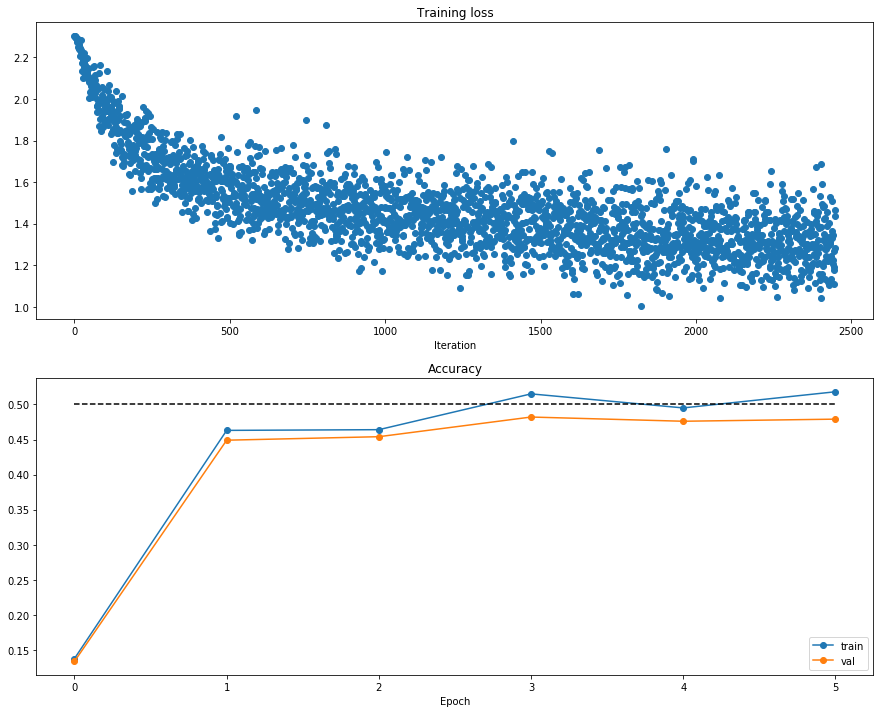

In [16]:
# Run this cell to visualize training loss and train / val accuracy

plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(solver.loss_history, 'o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(solver.train_acc_history, '-o', label='train')
plt.plot(solver.val_acc_history, '-o', label='val')
plt.plot([0.5] * len(solver.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

# Réseau de neurones multi-couches
Maintenant vous devez implanter un réseau ayant un nombre arbitraire de couches.

Pour ce faire, prenez connaissance de la classe `FullyConnectedNeuralNet` du fichier `ift725/classifiers/fc_net.py`.

Vous devez implanter **l'initialization, la propagation avant et la rétro-propagation**. Pour le moment, ne vous souciez pas de dropout ni de batch norm.

##  Fonction de perte et vérification du gradient

La prochaine cellule effectue une vérification dilligente.  Exécutez la cellule afin de vous assurez que la loss avec et sans régularisation fonctionne. 

In [17]:
from ift725.classifiers.fc_net import *
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,)) 

for reg in [0, 3.14]:
  print('Running check with reg = ', reg)
  model = FullyConnectedNeuralNet([H1, H2], input_dim=D, num_classes=C,
                            reg=reg, weight_scale=5e-2, dtype=np.float64)

  loss, grads = model.loss(X, y)
  print('Initial loss: ', loss)
    
  # Relative error should be below 1e-5
  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

Running check with reg =  0
Initial loss:  3.403084968110285
W1 relative error: 2.88e-07
W2 relative error: 1.02e-07
b1 relative error: 3.97e-09
b2 relative error: 5.28e-10
Running check with reg =  3.14
Initial loss:  10.27923672338272
W1 relative error: 9.69e-09
W2 relative error: 1.19e-08
b1 relative error: 1.32e-07
b2 relative error: 2.37e-09


## Question 1:

Pourquoi croyez-vous que les résultats de la cellule précédentes font foi d'une bonne fonction de perte?
     
**Votre réponse:** ...

Autre vérification diligente, assurez-vous que votre code peut "overfitter" sur un petit ensemble de 50 images. Pour ce faire, essayons un réseau à 3 couches cachées ayant chacune 100 neurones. Une recherche d'hyper-paramètres sera effectué pour trouver le bon taux d'apprentissage (learning rate) ainsi que le `weight_scale`.  Vous devriez être capable d'atteindre une justesse en entraînement de 100% avec 20 epochs.

In [18]:
num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

best_weight_scale = 0.
best_learning_rate = 0.
best_training_acc = 0.
results = []
##############################################################################
# TODO: Utilisez une instance de Solver pour entrainer un réseau à 3 couches #
#  et 100 neurones par couche à overfitter 50 images de CIFAR10.  Il est     #
#  suggéré d'effectuer une recherche d'hyperparamètres pour trouver le bon   #
#  `learning_rate` et le bon `weight_scale`.                                 #
##############################################################################
# TODO: Use a three-layer Net to overfit 50 training examples.
i=0
nb_weight_scale=25
nb_learning_rate=25
for weight_scale in np.logspace(-1,-1.8, nb_weight_scale):
    for learning_rate in np.logspace(-2,-4, nb_learning_rate):
        i+=1
        D, H1, H2, H3, C = 3072, 100, 100, 100, 10
        model = FullyConnectedNeuralNet([H1, H2, H3], input_dim=D, num_classes=C,
                                    reg=reg, weight_scale=weight_scale, dtype=np.float64)
        solver = None
        solver = Solver(model, small_data,
                        num_epochs=20, batch_size=50,
                        update_rule='adam',
                        optim_config={
                          'learning_rate': learning_rate,
                        },
                        verbose=False, print_every=1)
        solver.train()
        x = [weight_scale,learning_rate,solver.best_train_acc]
        results.append(x)
        print(i,"/",nb_weight_scale*nb_learning_rate,": ",solver.best_train_acc)
        if solver.best_train_acc>best_training_acc:
            best_learning_rate=learning_rate
            best_weight_scale=weight_scale
            best_training_acc=solver.best_train_acc
            print("---")

##############################################################################
#                             FIN DE VOTRE CODE                              #
##############################################################################

print('The best learning_rate, weight_scale and training accuracy are',best_weight_scale, best_learning_rate, best_training_acc)

/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


1 / 625 :  0.84
---
2 / 625 :  0.84
3 / 625 :  0.58
4 / 625 :  0.92
---
5 / 625 :  0.96
---
6 / 625 :  0.86
7 / 625 :  0.9
8 / 625 :  0.96
9 / 625 :  0.7
10 / 625 :  0.66
11 / 625 :  0.7
12 / 625 :  0.82
13 / 625 :  0.68
14 / 625 :  0.6
15 / 625 :  0.6
16 / 625 :  0.5
17 / 625 :  0.48
18 / 625 :  0.68
19 / 625 :  0.48
20 / 625 :  0.32
21 / 625 :  0.3
22 / 625 :  0.2
23 / 625 :  0.36
24 / 625 :  0.2
25 / 625 :  0.04
26 / 625 :  0.76
27 / 625 :  0.78
28 / 625 :  0.9
29 / 625 :  0.9
30 / 625 :  0.96
31 / 625 :  0.94
32 / 625 :  0.86
33 / 625 :  0.94
34 / 625 :  0.94
35 / 625 :  0.94
36 / 625 :  0.84
37 / 625 :  0.82
38 / 625 :  0.88
39 / 625 :  0.38
40 / 625 :  0.6
41 / 625 :  0.58
42 / 625 :  0.68
43 / 625 :  0.38
44 / 625 :  0.5
45 / 625 :  0.48
46 / 625 :  0.34
47 / 625 :  0.34
48 / 625 :  0.3
49 / 625 :  0.06
50 / 625 :  0.16
51 / 625 :  0.76
52 / 625 :  0.88
53 / 625 :  0.88
54 / 625 :  0.94
55 / 625 :  0.94
56 / 625 :  0.88
57 / 625 :  0.86
58 / 625 :  0.96
59 / 625 :  0.8
60 / 625 

467 / 625 :  0.54
468 / 625 :  0.54
469 / 625 :  0.5
470 / 625 :  0.58
471 / 625 :  0.52
472 / 625 :  0.64
473 / 625 :  0.54
474 / 625 :  0.52
475 / 625 :  0.38
476 / 625 :  0.68
477 / 625 :  0.58
478 / 625 :  0.64
479 / 625 :  0.64
480 / 625 :  0.8
481 / 625 :  0.8
482 / 625 :  0.84
483 / 625 :  0.86
484 / 625 :  0.82
485 / 625 :  0.8
486 / 625 :  0.8
487 / 625 :  0.88
488 / 625 :  0.96
489 / 625 :  0.84
490 / 625 :  0.76
491 / 625 :  0.74
492 / 625 :  0.76
493 / 625 :  0.62
494 / 625 :  0.46
495 / 625 :  0.4
496 / 625 :  0.68
497 / 625 :  0.48
498 / 625 :  0.48
499 / 625 :  0.56
500 / 625 :  0.24
501 / 625 :  0.46
502 / 625 :  0.78
503 / 625 :  0.54
504 / 625 :  0.64
505 / 625 :  0.8
506 / 625 :  0.72
507 / 625 :  0.88
508 / 625 :  0.78
509 / 625 :  0.86
510 / 625 :  0.9
511 / 625 :  0.76
512 / 625 :  0.82
513 / 625 :  0.92
514 / 625 :  0.86
515 / 625 :  0.8
516 / 625 :  0.86
517 / 625 :  0.8
518 / 625 :  0.58
519 / 625 :  0.58
520 / 625 :  0.74
521 / 625 :  0.66
522 / 625 :  0.52
52

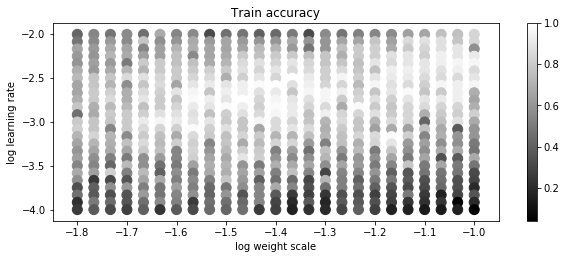

In [19]:
# Visualize the cross-validation results
# import math
marker_size = 100
x_scatter, x_label = [np.log10(x[0]) for x in results], 'log weight scale'
y_scatter, y_label = [np.log10(x[1]) for x in results], 'log learning rate'

# plot validation accuracy
colors = [x[2] for x in results]#[results[x] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.title('Train accuracy')
plt.show()

Maintenant, faites la même chose pour un réseau à 5 couches.

/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


1 / 625 |  final loss: inf  train_acc: 0.86
---




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


2 / 625 |  final loss: inf  train_acc: 0.9
---




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


3 / 625 |  final loss: inf  train_acc: 0.88




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


4 / 625 |  final loss: inf  train_acc: 0.82




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


5 / 625 |  final loss: inf  train_acc: 0.92
---




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


6 / 625 |  final loss: inf  train_acc: 0.96
---




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


7 / 625 |  final loss: 54751.7450999718  train_acc: 0.98
---




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


8 / 625 |  final loss: inf  train_acc: 0.88




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


9 / 625 |  final loss: inf  train_acc: 0.96




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


10 / 625 |  final loss: inf  train_acc: 0.68




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


11 / 625 |  final loss: inf  train_acc: 0.82




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


12 / 625 |  final loss: inf  train_acc: 0.88




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


13 / 625 |  final loss: inf  train_acc: 0.7




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


14 / 625 |  final loss: inf  train_acc: 0.42




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


15 / 625 |  final loss: inf  train_acc: 0.84




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


16 / 625 |  final loss: inf  train_acc: 0.64




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


17 / 625 |  final loss: inf  train_acc: 0.7




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


18 / 625 |  final loss: inf  train_acc: 0.7




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


19 / 625 |  final loss: inf  train_acc: 0.84




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


20 / 625 |  final loss: inf  train_acc: 0.64




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


21 / 625 |  final loss: inf  train_acc: 0.7




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


22 / 625 |  final loss: inf  train_acc: 0.66




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


23 / 625 |  final loss: inf  train_acc: 0.7




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


24 / 625 |  final loss: inf  train_acc: 0.46




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


25 / 625 |  final loss: inf  train_acc: 0.38




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


26 / 625 |  final loss: inf  train_acc: 0.94




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


27 / 625 |  final loss: inf  train_acc: 0.86




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


28 / 625 |  final loss: inf  train_acc: 0.94




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


29 / 625 |  final loss: inf  train_acc: 0.76




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


30 / 625 |  final loss: inf  train_acc: 0.72




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


31 / 625 |  final loss: 43768.576267647644  train_acc: 0.96




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


32 / 625 |  final loss: inf  train_acc: 0.84




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


33 / 625 |  final loss: inf  train_acc: 0.82




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


34 / 625 |  final loss: inf  train_acc: 0.92




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


35 / 625 |  final loss: inf  train_acc: 0.68




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


36 / 625 |  final loss: inf  train_acc: 0.84




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


37 / 625 |  final loss: inf  train_acc: 0.88




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


38 / 625 |  final loss: inf  train_acc: 0.56




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


39 / 625 |  final loss: inf  train_acc: 0.74




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


40 / 625 |  final loss: inf  train_acc: 0.8




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


41 / 625 |  final loss: inf  train_acc: 0.78




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


42 / 625 |  final loss: inf  train_acc: 0.7




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


43 / 625 |  final loss: inf  train_acc: 0.86




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


44 / 625 |  final loss: inf  train_acc: 0.58




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


45 / 625 |  final loss: inf  train_acc: 0.56




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


46 / 625 |  final loss: inf  train_acc: 0.7




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


47 / 625 |  final loss: inf  train_acc: 0.6




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


48 / 625 |  final loss: inf  train_acc: 0.54




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


49 / 625 |  final loss: inf  train_acc: 0.62




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


50 / 625 |  final loss: inf  train_acc: 0.54




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


51 / 625 |  final loss: inf  train_acc: 0.94




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


52 / 625 |  final loss: 29317.539537897024  train_acc: 0.96




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


53 / 625 |  final loss: inf  train_acc: 0.9




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


54 / 625 |  final loss: inf  train_acc: 0.76




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


55 / 625 |  final loss: 34637.43643337501  train_acc: 0.94




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


56 / 625 |  final loss: inf  train_acc: 0.8




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


57 / 625 |  final loss: inf  train_acc: 0.8




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


58 / 625 |  final loss: inf  train_acc: 0.96




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


59 / 625 |  final loss: inf  train_acc: 0.94




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


60 / 625 |  final loss: inf  train_acc: 0.92




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


61 / 625 |  final loss: inf  train_acc: 0.94




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


62 / 625 |  final loss: inf  train_acc: 0.88




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


63 / 625 |  final loss: inf  train_acc: 0.84




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


64 / 625 |  final loss: inf  train_acc: 0.74




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


65 / 625 |  final loss: inf  train_acc: 0.72




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


66 / 625 |  final loss: inf  train_acc: 0.56




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


67 / 625 |  final loss: inf  train_acc: 0.86




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


68 / 625 |  final loss: inf  train_acc: 0.7




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


69 / 625 |  final loss: inf  train_acc: 0.5




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


70 / 625 |  final loss: inf  train_acc: 0.56




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


71 / 625 |  final loss: inf  train_acc: 0.62




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


72 / 625 |  final loss: inf  train_acc: 0.52




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


73 / 625 |  final loss: inf  train_acc: 0.72




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


74 / 625 |  final loss: inf  train_acc: 0.44




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


75 / 625 |  final loss: inf  train_acc: 0.36




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


76 / 625 |  final loss: inf  train_acc: 0.76




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


77 / 625 |  final loss: inf  train_acc: 0.9




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


78 / 625 |  final loss: inf  train_acc: 0.78




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


79 / 625 |  final loss: 25510.130093987398  train_acc: 0.88




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


80 / 625 |  final loss: inf  train_acc: 0.8




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


81 / 625 |  final loss: 29043.531353540497  train_acc: 0.92




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


82 / 625 |  final loss: 30293.242449436486  train_acc: 0.96




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


83 / 625 |  final loss: inf  train_acc: 0.76




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


84 / 625 |  final loss: inf  train_acc: 0.94




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


85 / 625 |  final loss: inf  train_acc: 0.86




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


86 / 625 |  final loss: inf  train_acc: 0.74




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


87 / 625 |  final loss: inf  train_acc: 0.82




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


88 / 625 |  final loss: inf  train_acc: 0.62




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


89 / 625 |  final loss: inf  train_acc: 0.72




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


90 / 625 |  final loss: inf  train_acc: 0.78




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


91 / 625 |  final loss: inf  train_acc: 0.8




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


92 / 625 |  final loss: 38114.91378593026  train_acc: 0.94




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


93 / 625 |  final loss: inf  train_acc: 0.72




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


94 / 625 |  final loss: inf  train_acc: 0.78




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


95 / 625 |  final loss: inf  train_acc: 0.72




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


96 / 625 |  final loss: inf  train_acc: 0.8




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


97 / 625 |  final loss: inf  train_acc: 0.52




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


98 / 625 |  final loss: inf  train_acc: 0.82




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


99 / 625 |  final loss: inf  train_acc: 0.48




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


100 / 625 |  final loss: inf  train_acc: 0.5




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


101 / 625 |  final loss: 16118.241325188043  train_acc: 0.94




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


102 / 625 |  final loss: 17300.074096882  train_acc: 0.9




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


103 / 625 |  final loss: inf  train_acc: 0.9




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


104 / 625 |  final loss: 18989.783753623386  train_acc: 0.86




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


105 / 625 |  final loss: inf  train_acc: 0.9




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


106 / 625 |  final loss: 23531.49045278779  train_acc: 0.96




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


107 / 625 |  final loss: inf  train_acc: 0.96




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


108 / 625 |  final loss: 25149.645269698984  train_acc: 0.98




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


109 / 625 |  final loss: 26515.620247464387  train_acc: 0.86




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


110 / 625 |  final loss: 26868.022114370855  train_acc: 0.88




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


111 / 625 |  final loss: 28120.624105275463  train_acc: 0.76




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


112 / 625 |  final loss: inf  train_acc: 0.74




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


113 / 625 |  final loss: inf  train_acc: 0.9




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


114 / 625 |  final loss: inf  train_acc: 0.68




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


115 / 625 |  final loss: inf  train_acc: 0.64




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


116 / 625 |  final loss: inf  train_acc: 0.86




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


117 / 625 |  final loss: inf  train_acc: 0.48




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


118 / 625 |  final loss: inf  train_acc: 0.48




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


119 / 625 |  final loss: inf  train_acc: 0.74




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


120 / 625 |  final loss: inf  train_acc: 0.72




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


121 / 625 |  final loss: inf  train_acc: 0.64




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


122 / 625 |  final loss: inf  train_acc: 0.38




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


123 / 625 |  final loss: inf  train_acc: 0.76




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


124 / 625 |  final loss: inf  train_acc: 0.5




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


125 / 625 |  final loss: inf  train_acc: 0.64




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


126 / 625 |  final loss: 10730.751881202417  train_acc: 0.92




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


127 / 625 |  final loss: 11973.845814151176  train_acc: 0.88




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


128 / 625 |  final loss: 13423.821355133181  train_acc: 0.96




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


129 / 625 |  final loss: 14811.253853138995  train_acc: 0.94




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


130 / 625 |  final loss: 15923.422703425433  train_acc: 0.88




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


131 / 625 |  final loss: 16776.48042517454  train_acc: 0.94




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


132 / 625 |  final loss: 18249.507694197102  train_acc: 0.76




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


133 / 625 |  final loss: 19364.20787963724  train_acc: 0.96




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


134 / 625 |  final loss: 20873.48032068713  train_acc: 0.94




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


135 / 625 |  final loss: 22116.61172508572  train_acc: 0.8




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


136 / 625 |  final loss: 23310.098193496055  train_acc: 0.64




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


137 / 625 |  final loss: 23523.585503842183  train_acc: 0.96




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


138 / 625 |  final loss: 24726.916908118816  train_acc: 0.76




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


139 / 625 |  final loss: inf  train_acc: 0.9




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


140 / 625 |  final loss: 26347.221771917426  train_acc: 0.78




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


141 / 625 |  final loss: 26021.651500050742  train_acc: 0.96




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


142 / 625 |  final loss: 26745.460895384662  train_acc: 0.84




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


143 / 625 |  final loss: inf  train_acc: 0.7




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


144 / 625 |  final loss: inf  train_acc: 0.82




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


145 / 625 |  final loss: inf  train_acc: 0.64




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


146 / 625 |  final loss: 28495.987390088172  train_acc: 0.88




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


147 / 625 |  final loss: inf  train_acc: 0.64




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


148 / 625 |  final loss: inf  train_acc: 0.64




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


149 / 625 |  final loss: inf  train_acc: 0.6




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


150 / 625 |  final loss: inf  train_acc: 0.7




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


151 / 625 |  final loss: inf  train_acc: 0.86




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


152 / 625 |  final loss: 8171.627247763305  train_acc: 0.92




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


153 / 625 |  final loss: inf  train_acc: 0.92




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


154 / 625 |  final loss: 11186.573991597317  train_acc: 0.94




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


155 / 625 |  final loss: 12174.370380650624  train_acc: 0.86




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


156 / 625 |  final loss: 13017.573318227294  train_acc: 0.9




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


157 / 625 |  final loss: 15069.684039054233  train_acc: 0.84




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


158 / 625 |  final loss: 15337.96966975959  train_acc: 0.66




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


159 / 625 |  final loss: 16580.84077480998  train_acc: 0.86




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


160 / 625 |  final loss: 17172.4852896772  train_acc: 0.9




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


161 / 625 |  final loss: 18269.717377023113  train_acc: 0.82




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


162 / 625 |  final loss: 19367.95743924924  train_acc: 0.98




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


163 / 625 |  final loss: 19921.640004459103  train_acc: 0.92




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


164 / 625 |  final loss: 20956.925290906376  train_acc: 0.7




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


165 / 625 |  final loss: 21442.582951119883  train_acc: 0.58




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


166 / 625 |  final loss: 22203.789415167448  train_acc: 0.78




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


167 / 625 |  final loss: inf  train_acc: 0.9




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


168 / 625 |  final loss: 22832.002579404856  train_acc: 0.94




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


169 / 625 |  final loss: 23598.6950291505  train_acc: 0.74




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


170 / 625 |  final loss: 23473.107575717713  train_acc: 0.84




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


171 / 625 |  final loss: 24115.921972483833  train_acc: 0.72




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


172 / 625 |  final loss: inf  train_acc: 0.62




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


173 / 625 |  final loss: inf  train_acc: 0.66




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


174 / 625 |  final loss: 24973.45206787941  train_acc: 0.56




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


175 / 625 |  final loss: inf  train_acc: 0.56




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


176 / 625 |  final loss: 5695.834415917653  train_acc: 0.8




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


177 / 625 |  final loss: 5881.078146762433  train_acc: 0.78




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


178 / 625 |  final loss: 7362.3442404905  train_acc: 0.96




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


179 / 625 |  final loss: 7965.358905602743  train_acc: 0.9




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


180 / 625 |  final loss: 9317.986911737256  train_acc: 0.88




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


181 / 625 |  final loss: 10359.250723679192  train_acc: 0.84




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


182 / 625 |  final loss: 11160.349151741331  train_acc: 0.9




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


183 / 625 |  final loss: 12152.40373174823  train_acc: 0.98




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


184 / 625 |  final loss: 13083.550228471935  train_acc: 0.92




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


185 / 625 |  final loss: 14274.323947346353  train_acc: 0.92




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


186 / 625 |  final loss: 14712.175343356419  train_acc: 0.7




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


187 / 625 |  final loss: 15720.587933028364  train_acc: 0.96




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


188 / 625 |  final loss: 16343.861109009205  train_acc: 0.6




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


189 / 625 |  final loss: 17113.858896495287  train_acc: 0.86




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


190 / 625 |  final loss: 17695.89887026886  train_acc: 0.9




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


191 / 625 |  final loss: 18360.631404751788  train_acc: 0.86




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


192 / 625 |  final loss: 18658.598211501863  train_acc: 0.78




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


193 / 625 |  final loss: inf  train_acc: 0.88




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


194 / 625 |  final loss: 19705.852402717504  train_acc: 0.68




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


195 / 625 |  final loss: 19957.47563754268  train_acc: 0.84




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


196 / 625 |  final loss: 20337.813925608054  train_acc: 0.64




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


197 / 625 |  final loss: 20529.384958226874  train_acc: 0.68




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


198 / 625 |  final loss: 20958.702995206393  train_acc: 0.64




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


199 / 625 |  final loss: 21136.969641179483  train_acc: 0.8




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


200 / 625 |  final loss: 21510.51015612864  train_acc: 0.32




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


201 / 625 |  final loss: 3160.9468556514785  train_acc: 0.8




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


202 / 625 |  final loss: 4425.086717296647  train_acc: 0.76




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


203 / 625 |  final loss: 4451.520571891656  train_acc: 0.88




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


204 / 625 |  final loss: 5539.444679525495  train_acc: 0.9




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


205 / 625 |  final loss: 6343.645999767541  train_acc: 0.9




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


206 / 625 |  final loss: 8019.126858667514  train_acc: 0.86




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


207 / 625 |  final loss: 8839.52905112201  train_acc: 1.0
---




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


208 / 625 |  final loss: 9288.1048130888  train_acc: 0.86




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


209 / 625 |  final loss: 10279.75336736561  train_acc: 0.9




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


210 / 625 |  final loss: 10723.70808536926  train_acc: 0.88




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


211 / 625 |  final loss: 11723.881849842492  train_acc: 1.0




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


212 / 625 |  final loss: 12617.18482395475  train_acc: 0.96




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


213 / 625 |  final loss: 12978.69780752185  train_acc: 0.84




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


214 / 625 |  final loss: 14149.204315532963  train_acc: 0.86




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


215 / 625 |  final loss: 14553.920423170854  train_acc: 0.88




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


216 / 625 |  final loss: 15029.162201356363  train_acc: 0.7




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


217 / 625 |  final loss: 15548.027886676913  train_acc: 0.76




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


218 / 625 |  final loss: 16112.853032562645  train_acc: 0.66




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


219 / 625 |  final loss: 16562.960772060946  train_acc: 0.64




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


220 / 625 |  final loss: 16646.62126008535  train_acc: 0.58




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


221 / 625 |  final loss: 17178.063551681695  train_acc: 0.82




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


222 / 625 |  final loss: 17413.07221180402  train_acc: 0.76




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


223 / 625 |  final loss: 17689.865060825763  train_acc: 0.64




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


224 / 625 |  final loss: 17873.401681902513  train_acc: 0.5




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


225 / 625 |  final loss: 18033.09807961927  train_acc: 0.64




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


226 / 625 |  final loss: 2209.7097663309833  train_acc: 0.8




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


227 / 625 |  final loss: 2931.580957224552  train_acc: 0.72




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


228 / 625 |  final loss: 3381.1141012972257  train_acc: 0.9




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


229 / 625 |  final loss: 4325.924064206918  train_acc: 0.76




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


230 / 625 |  final loss: 4455.350371712049  train_acc: 0.72




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


231 / 625 |  final loss: 5888.984053279255  train_acc: 0.96




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


232 / 625 |  final loss: 6336.089361132412  train_acc: 0.84




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


233 / 625 |  final loss: 7080.316934428052  train_acc: 0.88




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


234 / 625 |  final loss: 7909.375390359781  train_acc: 0.8




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


235 / 625 |  final loss: 8733.783776752369  train_acc: 0.96




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


236 / 625 |  final loss: 9363.421984248824  train_acc: 0.9




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


237 / 625 |  final loss: 9775.839856687  train_acc: 0.6




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


238 / 625 |  final loss: 10572.367732056058  train_acc: 0.88




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


239 / 625 |  final loss: 11314.217849840838  train_acc: 0.66




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


240 / 625 |  final loss: 11828.905805673097  train_acc: 1.0




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


241 / 625 |  final loss: 12156.322694262988  train_acc: 0.8




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


242 / 625 |  final loss: 12508.973123733262  train_acc: 0.8




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


243 / 625 |  final loss: 13293.710714314539  train_acc: 0.94




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


244 / 625 |  final loss: 13786.227009960043  train_acc: 0.72




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


245 / 625 |  final loss: 13714.61245875811  train_acc: 0.82




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


246 / 625 |  final loss: 14175.889815592613  train_acc: 0.46




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


247 / 625 |  final loss: 14632.648057190532  train_acc: 0.6




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


248 / 625 |  final loss: 14843.120278250812  train_acc: 0.58




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


249 / 625 |  final loss: 14963.041601037523  train_acc: 0.82




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


250 / 625 |  final loss: 15235.114072751607  train_acc: 0.48




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


251 / 625 |  final loss: 1226.1452091086796  train_acc: 0.72




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


252 / 625 |  final loss: 1928.4694401033212  train_acc: 0.86




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


253 / 625 |  final loss: 2311.3296335740506  train_acc: 0.82




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


254 / 625 |  final loss: 2845.461567189013  train_acc: 0.92




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


255 / 625 |  final loss: 3470.5199841005315  train_acc: 0.82




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


256 / 625 |  final loss: 3976.688344338712  train_acc: 0.9




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


257 / 625 |  final loss: 4590.404812830892  train_acc: 0.96




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


258 / 625 |  final loss: 5428.665639051789  train_acc: 0.86




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


259 / 625 |  final loss: 6100.917258782154  train_acc: 0.76




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


260 / 625 |  final loss: 6604.941587269321  train_acc: 0.8




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


261 / 625 |  final loss: 7294.291420092817  train_acc: 0.98




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


262 / 625 |  final loss: 7940.578822088066  train_acc: 1.0




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


263 / 625 |  final loss: 8476.204573603995  train_acc: 0.72




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


264 / 625 |  final loss: 9108.12877353113  train_acc: 0.68




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


265 / 625 |  final loss: 9570.499247667827  train_acc: 0.94




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


266 / 625 |  final loss: 10223.333356526542  train_acc: 0.7




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


267 / 625 |  final loss: 10468.855013660535  train_acc: 0.52




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


268 / 625 |  final loss: 10884.840273937594  train_acc: 0.84




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


269 / 625 |  final loss: 11409.846431438986  train_acc: 0.7




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


270 / 625 |  final loss: 11586.195675775869  train_acc: 0.8




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


271 / 625 |  final loss: 11871.758195649256  train_acc: 0.94




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


272 / 625 |  final loss: 12329.913307329432  train_acc: 0.8




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


273 / 625 |  final loss: 12463.367599846682  train_acc: 0.66




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


274 / 625 |  final loss: 12660.130159652708  train_acc: 0.72


275 / 625 |  final loss: 12818.496965457773  train_acc: 0.58




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


276 / 625 |  final loss: 982.0626519313744  train_acc: 0.78




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


277 / 625 |  final loss: 1300.5599590052245  train_acc: 0.84




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


278 / 625 |  final loss: 1509.6901374726137  train_acc: 0.88




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


279 / 625 |  final loss: 2121.791355666576  train_acc: 0.86


280 / 625 |  final loss: 2276.3775440927457  train_acc: 0.92




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


281 / 625 |  final loss: 2959.4934106718865  train_acc: 0.88


282 / 625 |  final loss: 3307.623540951598  train_acc: 0.9




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


283 / 625 |  final loss: 4047.229418196062  train_acc: 0.9


284 / 625 |  final loss: 4440.9633556083945  train_acc: 0.88


285 / 625 |  final loss: 5267.5549514893655  train_acc: 0.94


286 / 625 |  final loss: 5740.182223663753  train_acc: 0.96


287 / 625 |  final loss: 6437.363120019961  train_acc: 0.9


288 / 625 |  final loss: 6705.314116075381  train_acc: 0.9


289 / 625 |  final loss: 7280.156307465719  train_acc: 0.72


290 / 625 |  final loss: 7735.362911561425  train_acc: 1.0


291 / 625 |  final loss: 8117.373076097761  train_acc: 0.96


292 / 625 |  final loss: 8731.278525139844  train_acc: 0.72


293 / 625 |  final loss: 8952.019986093397  train_acc: 0.8




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


294 / 625 |  final loss: 9427.045176624213  train_acc: 0.72




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


295 / 625 |  final loss: 9639.534536672234  train_acc: 0.84




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


296 / 625 |  final loss: 9939.930861192606  train_acc: 0.84


297 / 625 |  final loss: 10194.556857536178  train_acc: 0.58


298 / 625 |  final loss: 10375.149923490882  train_acc: 0.74




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


299 / 625 |  final loss: 10637.274851670809  train_acc: 0.66


300 / 625 |  final loss: 10877.303186748479  train_acc: 0.4


301 / 625 |  final loss: 661.0458639622993  train_acc: 0.68


302 / 625 |  final loss: 834.3722293872925  train_acc: 0.78




/home/yannis/Documents/uds/ift725/tp2RN/prog/ift725/layers.py:649: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(probs[np.arange(len(y)),y]))/len(y)


303 / 625 |  final loss: 1059.1094177384966  train_acc: 0.58


304 / 625 |  final loss: 1330.9163400103048  train_acc: 0.72


305 / 625 |  final loss: 1589.4545940118376  train_acc: 0.82


306 / 625 |  final loss: 2005.6644255660983  train_acc: 0.9


307 / 625 |  final loss: 2567.6680605710567  train_acc: 0.9


308 / 625 |  final loss: 3028.321585942838  train_acc: 0.94


309 / 625 |  final loss: 3432.7671975441667  train_acc: 0.94


310 / 625 |  final loss: 3998.153350721148  train_acc: 0.92


311 / 625 |  final loss: 4487.170332803347  train_acc: 0.92


312 / 625 |  final loss: 4947.550944268902  train_acc: 0.62


313 / 625 |  final loss: 5319.421225366097  train_acc: 0.84


314 / 625 |  final loss: 5953.142135622582  train_acc: 0.92


315 / 625 |  final loss: 6397.7276723921095  train_acc: 0.94


316 / 625 |  final loss: 6706.007134028891  train_acc: 0.8


317 / 625 |  final loss: 7012.738209494721  train_acc: 0.88


318 / 625 |  final loss: 7313.897398205082  train_acc: 0.64


319 

435 / 625 |  final loss: 934.323167554893  train_acc: 0.6


436 / 625 |  final loss: 1131.4391183962236  train_acc: 0.96


437 / 625 |  final loss: 1325.4132584730214  train_acc: 0.84


438 / 625 |  final loss: 1582.0749773450868  train_acc: 0.88


439 / 625 |  final loss: 1767.4223411561998  train_acc: 0.88


440 / 625 |  final loss: 2004.285388059758  train_acc: 0.92


441 / 625 |  final loss: 2243.7732699776034  train_acc: 0.72


442 / 625 |  final loss: 2437.9162763730988  train_acc: 0.58


443 / 625 |  final loss: 2630.1017118800655  train_acc: 0.86


444 / 625 |  final loss: 2851.1063946459913  train_acc: 0.6


445 / 625 |  final loss: 3010.1140757174526  train_acc: 0.92


446 / 625 |  final loss: 3202.1544516310646  train_acc: 0.74


447 / 625 |  final loss: 3355.6584398810237  train_acc: 0.82


448 / 625 |  final loss: 3496.054966200456  train_acc: 0.94


449 / 625 |  final loss: 3641.5885958007425  train_acc: 0.44


450 / 625 |  final loss: 3771.167167601494  train_acc: 0.52



567 / 625 |  final loss: 759.0279767105117  train_acc: 0.58


568 / 625 |  final loss: 867.4294326028504  train_acc: 0.84


569 / 625 |  final loss: 971.672235575202  train_acc: 0.9


570 / 625 |  final loss: 1068.022396818249  train_acc: 0.86


571 / 625 |  final loss: 1161.3048817581498  train_acc: 0.74


572 / 625 |  final loss: 1258.1853111664177  train_acc: 0.76


573 / 625 |  final loss: 1341.5203519747342  train_acc: 0.74


574 / 625 |  final loss: 1425.6068946757425  train_acc: 0.68


575 / 625 |  final loss: 1510.165344801382  train_acc: 0.7


576 / 625 |  final loss: 92.03119349453343  train_acc: 0.34


577 / 625 |  final loss: 94.67541676645408  train_acc: 0.3


578 / 625 |  final loss: 93.32989963312767  train_acc: 0.36


579 / 625 |  final loss: 88.40434169202267  train_acc: 0.3


580 / 625 |  final loss: 84.09000190107957  train_acc: 0.3


581 / 625 |  final loss: 79.40586956722802  train_acc: 0.52


582 / 625 |  final loss: 80.08617228880301  train_acc: 0.44


583 / 625 

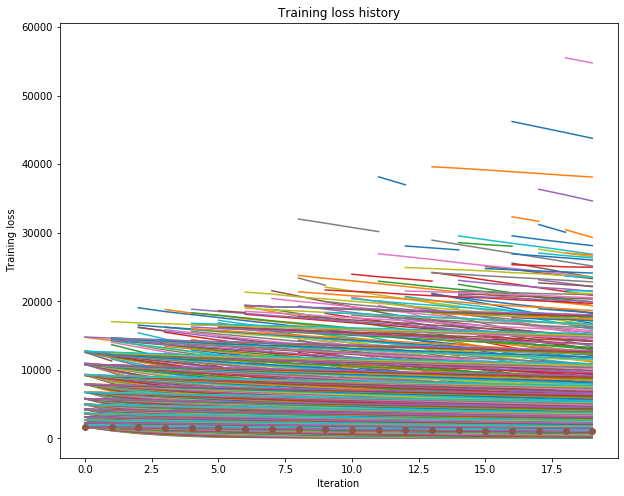

The best learning_rate, weight_scale and training accuracy are 0.13593563908785256 0.005011872336272725 1.0


In [24]:
num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

##############################################################################
# TODO: Utilisez une instance de Solver pour entrainer un réseau à 5 couches #
#  à 100 neurones à overfitter 50 images de CIFAR10.  Il est suggérer de     #
#  d'effectuer une recherche d'hyperparamètres pour trouver le bon           #
#  `learning_rate` et le bon `weight_scale`.                                 #
##############################################################################
best_weight_scale = 0.
best_learning_rate = 0.
best_training_acc = 0.

for learning_rate in np.logspace (-3,-4, 10):
    for weight_scale in np.logspace(-1.7,-2, 10):
        model = FullyConnectedNeuralNet([100, 100, 100, 100],
                      weight_scale=weight_scale, dtype=np.float64)
        solver = None
        solver = Solver(model, small_data,
                        verbose = False, num_epochs=20, batch_size= 50 ,
                        update_rule='sgd',
                        optim_config={
                          'learning_rate': learning_rate,
                        })
        solver.train()
        
        if np.max(solver.train_acc_history) > best_training_acc:
            best_training_acc = np.max(solver.train_acc_history)
            best_weight_scale = weight_scale
            best_learning_rate = learning_rate
            print('The best learning_rate, weight_scale and training accuracy are',best_weight_scale, best_learning_rate, best_training_acc)
            
            plt.subplot(2, 1, 1)
            plt.title('Training loss')
            plt.plot(solver.loss_history, 'o')
            plt.xlabel('Iteration')

results = []
i=0
nb_weight_scale=25
nb_learning_rate=25
for weight_scale in np.logspace(-0.6,-1.4, nb_weight_scale):
    for learning_rate in np.logspace(-2,-3.2, nb_learning_rate):
        i+=1
        D, H1, H2, H3, H4, C = 3072, 100, 100, 100, 100, 10
        model = FullyConnectedNeuralNet([H1, H2, H3, H4], input_dim=D, num_classes=C,
                                    reg=reg, weight_scale=weight_scale, dtype=np.float64)
        solver = None
        solver = Solver(model, small_data,
                        num_epochs=20, batch_size=50,
                        update_rule='adam',
                        optim_config={
                          'learning_rate': learning_rate,
                        },
                        verbose=False, print_every=10)
        solver.train()
        x = [weight_scale,learning_rate,solver.best_train_acc]
        results.append(x)
        print(i,"/",nb_weight_scale*nb_learning_rate,"| ",'final loss:', solver.loss_history[-1], ' train_acc:', solver.best_train_acc)
        
        plt.plot(solver.loss_history)
        if solver.best_train_acc>best_training_acc:
            best_learning_rate=learning_rate
            best_weight_scale=weight_scale
            best_training_acc=solver.best_train_acc
            print("---")
        print('\n')


plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

##############################################################################
#                             FIN DE VOTRE CODE                              #
##############################################################################
print('The best learning_rate, weight_scale and training accuracy are',best_weight_scale, best_learning_rate, best_training_acc)

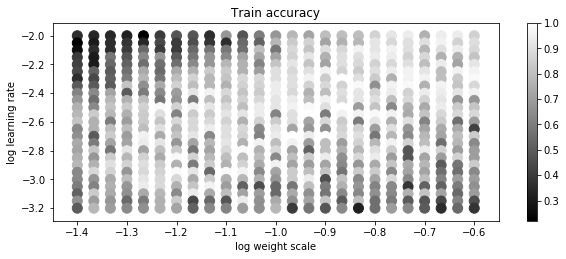

In [25]:
# Visualize the cross-validation results
# import math
marker_size = 100
x_scatter, x_label = [np.log10(x[0]) for x in results], 'log weight scale'
y_scatter, y_label = [np.log10(x[1]) for x in results], 'log learning rate'

# plot validation accuracy
colors = [x[2] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.title('Train accuracy')
plt.show()

# Descente de gradient ++
Jusqu'à présent nous avons utilisé l'algorithmes de base de la descente de gradient (SGD-stochastic gradient descent). Ici nous testerons d'autres algorithmes plus sophistiqués.

# SGD+Momentum
SGD+momentum est très largement utilisé.  Ouvrez  `ift725/optim.py` et prenez connaissance du code et implémentez la fonction `sgd_momentum` et exécutez la cellule que voici. Votre erreur devrait être inféreieure à 1e-6.

In [22]:
from ift725.optim import sgd_momentum

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
v = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-3, 'velocity': v}
next_w, _ = sgd_momentum(w, dw, config=config)

expected_next_w = np.asarray([
    [-0.39994,    -0.34737526, -0.29481053, -0.24224579, -0.18968105],
    [-0.13711632, -0.08455158, -0.03198684,  0.02057789,  0.07314263],
    [ 0.12570737,  0.17827211,  0.23083684,  0.28340158,  0.33596632],
    [ 0.38853105,  0.44109579,  0.49366053,  0.54622526,  0.59879   ]])
expected_velocity = np.asarray([
    [-0.06 ,       0.00684211,  0.07368421,  0.14052632,  0.20736842],
    [ 0.27421053,  0.34105263,  0.40789474,  0.47473684,  0.54157895],
    [ 0.60842105,  0.67526316,  0.74210526,  0.80894737,  0.87578947],
    [ 0.94263158,  1.00947368,  1.07631579,  1.14315789,  1.21      ]])

# Error should be below 1e-06
print('next_w error: ', rel_error(next_w, expected_next_w))
print('velocity error: ', rel_error(expected_velocity, config['velocity']))

TypeError: unsupported operand type(s) for -: 'NoneType' and 'float'

Maintenant, excécutez cette cellule.  Normalement, le réseau à 6 couches devrait s'entraîner plus rapidement avec SGD+momentum qu'avec SGD.

In [ ]:
num_train = 4000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

solvers = {}

for update_rule in ['sgd', 'sgd_momentum']:
  print('running with ', update_rule)
  model = FullyConnectedNeuralNet([100, 100, 100, 100, 100], weight_scale=5e-2)

  solver = Solver(model, small_data,
                  num_epochs=10, batch_size=100,
                  update_rule=update_rule,
                  optim_config={
                    'learning_rate': 1e-2,
                  },
                  verbose=True)
  solvers[update_rule] = solver
  solver.train()
  print()

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for update_rule, solver in solvers.items():
  plt.subplot(3, 1, 1)
  plt.plot(solver.loss_history, '-o', label=update_rule)
  
  plt.subplot(3, 1, 2)
  plt.plot(solver.train_acc_history, '-o', label=update_rule)

  plt.subplot(3, 1, 3)
  plt.plot(solver.val_acc_history, '-o', label=update_rule)
  
for i in [1, 2, 3]:
  plt.subplot(3, 1, i)
  plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

# RMSProp et Adam
RMSProp [1] et Adam [2] sont d'autres algorithmes de descente de gradient dont le code est dans le fichier `ift725/optim.py`.   Alors que le code de Adam vous est fournit, vous devez rédigé celui de RMSProp.

[1] Tijmen Tieleman and Geoffrey Hinton. "Lecture 6.5-rmsprop: Divide the gradient by a running average of its recent magnitude." COURSERA: Neural Networks for Machine Learning 4 (2012).

[2] Diederik Kingma and Jimmy Ba, "Adam: A Method for Stochastic Optimization", ICLR 2015.

In [ ]:
# Test RMSProp implementation; you should see errors less than 1e-7
import numpy as np
from ift725.optim import rmsprop

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
cache = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'cache': cache}
next_w, _ = rmsprop(w, dw, config=config)

expected_next_w = np.asarray([
    [-0.39,       -0.33846964, -0.2868865,  -0.23525427, -0.18357633],
    [-0.13185574, -0.0800953,  -0.02829757,  0.02353511,  0.07540058],
    [ 0.12729687,  0.17922215,  0.23117507,  0.28315533,  0.33516143],
    [ 0.38719188,  0.43924528,  0.49132033,  0.54341585,  0.59553073]])
expected_cache = np.asarray([
    [0.6,        0.61510526, 0.63021053, 0.64531579, 0.66042105],
 [0.67552632, 0.69063158, 0.70573684, 0.72084211, 0.73594737],
 [0.75105263, 0.76615789, 0.78189474, 0.79805263, 0.81421053],
 [0.83036842, 0.84652632, 0.86268421, 0.87884211, 0.895     ]])  


print('next_w error: ', rel_error(expected_next_w, next_w))
print('cache error: ', rel_error(expected_cache, config['cache']))

In [ ]:
# Test Adam implementation; you should see errors around 1e-7 or less
from ift725.optim import adam

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
m = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)
v = np.linspace(0.7, 0.5, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'm': m, 'v': v, 't': 5}
next_w, config = adam(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.40094747, -0.34836187, -0.29577703, -0.24319299, -0.19060977],
  [-0.1380274,  -0.08544591, -0.03286534,  0.01971428,  0.0722929],
  [ 0.1248705,   0.17744702,  0.23002243,  0.28259667,  0.33516969],
  [ 0.38774145,  0.44031188,  0.49288093,  0.54544852,  0.59801459]])
expected_v = np.asarray([
  [ 0.69966,     0.68908382,  0.67851319,  0.66794809,  0.65738853,],
  [ 0.64683452,  0.63628604,  0.6257431,   0.61520571,  0.60467385,],
  [ 0.59414753,  0.58362676,  0.57311152,  0.56260183,  0.55209767,],
  [ 0.54159906,  0.53110598,  0.52061845,  0.51013645,  0.49966,   ]])
expected_m = np.asarray([
  [ 0.48,        0.49947368,  0.51894737,  0.53842105,  0.55789474],
  [ 0.57736842,  0.59684211,  0.61631579,  0.63578947,  0.65526316],
  [ 0.67473684,  0.69421053,  0.71368421,  0.73315789,  0.75263158],
  [ 0.77210526,  0.79157895,  0.81105263,  0.83052632,  0.85      ]])

print('next_w error: ', rel_error(expected_next_w, next_w))
print('v error: ', rel_error(expected_v, config['v']))
print('m error: ', rel_error(expected_m, config['m']))

Exécuter le code que voici afin de comparer ces différent algorithmes.  En pricipe Adam devrait être le meilleur algorithme.

In [ ]:
learning_rates = {'rmsprop': 1e-4, 'adam': 1e-3}
for update_rule in ['adam', 'rmsprop']:
  print('running with ', update_rule)
  model = FullyConnectedNeuralNet([100, 100, 100, 100, 100], weight_scale=5e-2)

  solver = Solver(model, small_data,
                  num_epochs=10, batch_size=100,
                  update_rule=update_rule,
                  optim_config={
                    'learning_rate': learning_rates[update_rule]
                  },
                  verbose=True)
  solvers[update_rule] = solver
  solver.train()
  print()

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for update_rule, solver in solvers.items():
  plt.subplot(3, 1, 1)
  plt.plot(solver.loss_history, 'o', label=update_rule)
  
  plt.subplot(3, 1, 2)
  plt.plot(solver.train_acc_history, '-o', label=update_rule)

  plt.subplot(3, 1, 3)
  plt.plot(solver.val_acc_history, '-o', label=update_rule)
  
for i in [1, 2, 3]:
  plt.subplot(3, 1, i)
  plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

# Entraînez un bon model!
Entraînez le meilleur réseau de neurones possible sur CIFAR-10 et mettez le meilleur modèle dans la variable `best_model`. Vous devriez avoir au moins une justesse 50% (voire même 55%) en validation et en test.

Plus tard dans le devoir, on vous demandera d'entrainer et de tester une réseau convolutionnel sur CIFAR-10.  Vous verrez alors que cette architecture est supérieure aux réseaus de neurones pleinement connectés.

NOTE: il serait judicieux de compléter le notebook `BatchNormalization.ipynb` et `Dropout.ipynb` avant de compléter cette dernière partie.

In [ ]:
do_delete = True

In [ ]:
if do_delete:
    trys = []
    best_try = -1
    best_val_acc = 0
    print('Deleted trys')
else:
    print('Did not delete trys')
do_delete = False

In [ ]:
best_model = None
################################################################################
# TODO: Entrainez le meilleur FullyConnectedNeuralNet que vous pouvez sur les  #
#  données CIFAR-10. Vous pourriez trouver la normalization par lots et le     #
#  dropout utile. Stockez votre meilleur modèle dans la variable best_model.   #
################################################################################

def uniform(minv, maxv):
    return np.random.rand() * (maxv - minv) + minv

if 'trys' not in locals():
    trys = []
    best_try = -1
    best_val_acc = 0
for i in range(1):
    # reg 0.00779190546432  lr 0.000423844376859
    # reg 0.000204588367827 lr 0.000529341067109
    weight_scale = 3e-2  # 10 ** uniform(-3, -1)
    lr = 10 ** -2.5  # 10 ** uniform(-4, -2)
    reg = 1e-10  # 10 ** uniform(-6, -3)
    
    model = FullyConnectedNeuralNet([100] * 5, weight_scale=weight_scale, reg=reg, use_batchnorm=True)

    solver = Solver(model, data,
                  num_epochs=30, batch_size=100,
                  update_rule='adam',
                  optim_config={
                    'learning_rate': lr
                  },
                  print_every=200,
                  verbose=True)
    solver.train()
    
    max_val_acc = np.max(solver.val_acc_history)
    cur_index = len(trys)
    print('Try', cur_index, 'Max accu. val.', max_val_acc, 'p:', weight_scale, reg, lr, ('Record!' if max_val_acc > best_val_acc else ''))
    trys.append({
            'ws': weight_scale, 'reg': reg, 'lr': lr,
            'maxvacc': max_val_acc,
            'lossh': solver.loss_history,
            'tacch': solver.train_acc_history,
            'vacch': solver.val_acc_history,
            'model': model
        })
    
    if max_val_acc > best_val_acc:
        best_val_acc = max_val_acc
        best_try = cur_index
        
print('Best try:', best_try)
print('Total tries', len(trys))
################################################################################
#                              FIN DE VOTRE CODE                               #
################################################################################

In [ ]:
# Visualize the cross-validation results
forget = 0
new_tries = trys[forget:]
marker_size = 100
#x_scatter, x_label = [np.log10(x['ws']) for x in new_tries], 'log weight scale'
x_scatter, x_label = [np.log10(x['lr']) for x in new_tries], 'log lr'
y_scatter, y_label = [np.log10(x['reg']) for x in new_tries], 'log reg'

# plot validation accuracy
colors = [x['maxvacc'] for x in new_tries] # default size of markers is 20
isorted = np.argsort(colors)
x_scatter = np.asarray(x_scatter)[isorted]
y_scatter = np.asarray(y_scatter)[isorted]
colors = np.asarray(colors)[isorted]
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.title('Validation accuracy')
plt.show()

In [ ]:
ref = trys[best_try]
best_try = -1
plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')
plt.plot(trys[best_try]['lossh'], '-')
plt.plot(ref['lossh'], '-')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.plot(trys[best_try]['tacch'], '-', label='Train')
plt.plot(trys[best_try]['vacch'], '-', label='Valid')
plt.plot(ref['tacch'], '-', label='Train ref')
plt.plot(ref['vacch'], '-', label='Valid ref')
plt.legend(loc='lower center')

plt.tight_layout(pad=0, w_pad=0, h_pad=2)
plt.show()

# Test your model
Run your best model on the validation and test sets. You should achieve above 53% accuracy on the validation set.

In [ ]:
best_model = trys[best_try]['model']
X_test = data['X_test']
y_test = data['y_test']
X_val  = data['X_val']
y_val  = data['y_val']
y_test_pred = np.argmax(best_model.loss(X_test), axis=1)
y_val_pred = np.argmax(best_model.loss(X_val), axis=1)
print('Validation set accuracy: ', (y_val_pred == y_val).mean())
print('Test set accuracy: ', (y_test_pred == y_test).mean())